# PCE Data Analysis

- Data loading and visualization 
- Statistical analysis
- Time-series analsyis, including SARIMA, SVM, LSTM models. 
- Forecasting results
- Comparison of results of different models
- Learn relationship between PCE and other daily data within the month to see if the daily data can be used as referenceto predict PCE. 

## 1. Setup and Imports

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

## 2. Data Loading and Initial Exploration 
#(original data -- df)
# Even though the date is 2025/5/1, the PCE is actually the PCE for May.

In [67]:
# Load the PCE data
# Original data is downloaded from FRED, https://fred.stlouisfed.org/series/PCE
df = pd.read_excel("PCE.xlsx")

# Convert the first column to datetime and set as index
# The observation_date column appears to be in Excel date serial number format (monthly data)
df['observation_date'] = pd.to_datetime(df['observation_date'],origin='1899-12-30', unit='D')
# Adjust the dates to the end of the month
df['observation_date'] = df['observation_date'] + pd.offsets.MonthEnd(0)
# Set the date column as index
df.set_index('observation_date', inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values:")

# Show summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))

print(df)


Missing values:

Summary Statistics:
            PCE($B)
count    797.000000
mean    5906.814053
std     5426.584961
min      306.100000
25%     1047.000000
50%     4117.000000
75%     9972.800000
max    20622.000000
                  PCE($B)
observation_date         
1959-01-31          306.1
1959-02-28          309.6
1959-03-31          312.7
1959-04-30          312.2
1959-05-31          316.1
...                   ...
2025-01-31        20370.0
2025-02-28        20436.3
2025-03-31        20578.5
2025-04-30        20622.0
2025-05-31        20592.7

[797 rows x 1 columns]


## 3. Data Visualizations

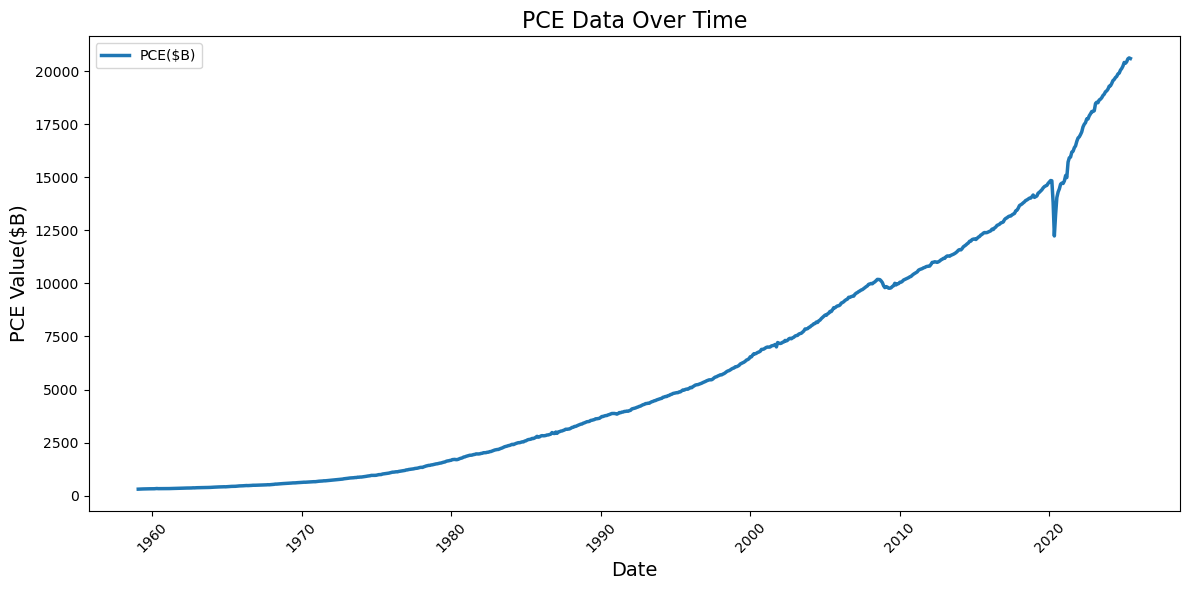

In [72]:
# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, palette="tab10", linewidth=2.5)

# Customize the plot
plt.title('PCE Data Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PCE Value($B)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

                  PCE Monthly Change(%)
observation_date                       
1959-02-28                     1.143417
1959-03-31                     1.001292
1959-04-30                    -0.159898
1959-05-31                     1.249199
1959-06-30                     0.664347
...                                 ...
2025-01-31                    -0.186691
2025-02-28                     0.325479
2025-03-31                     0.695821
2025-04-30                     0.211386
2025-05-31                    -0.142081

[796 rows x 1 columns]


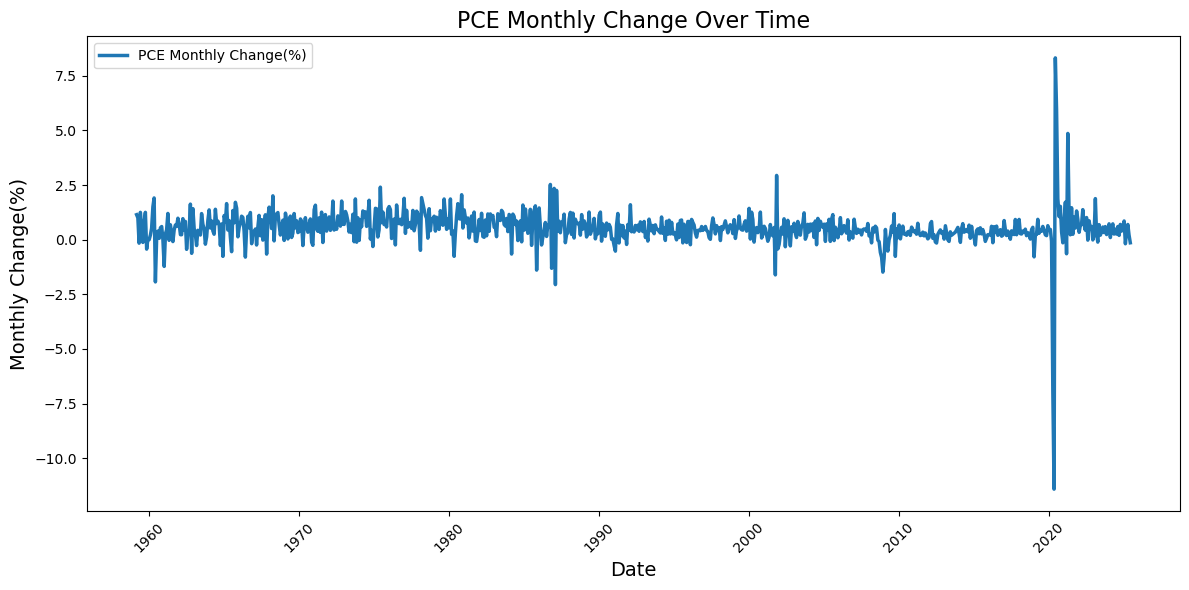

In [75]:
df_pct_change=df.pct_change()*100
df_pct_change=df_pct_change.dropna()
df_pct_change.rename(columns={'PCE($B)': 'PCE Monthly Change(%)'}, inplace=True)
print(df_pct_change)
#visualize the pct_change
# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pct_change, palette="tab10", linewidth=2.5)

# Customize the plot
plt.title('PCE Monthly Change Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Change(%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [79]:
Q1 = df_pct_change.quantile(0.05)
Q3 = df_pct_change.quantile(0.95)

# Calculate the IQR
IQR = Q3 - Q1

# Determine outliers
outliers = (df_pct_change < (Q1 - 1.5 * IQR)) | (df_pct_change > (Q3 + 1.5 * IQR))

# Extract outlier data and their index dates
outlier_data = df_pct_change[outliers]
outlier_dates = outlier_data.index

# Print outlier data and their corresponding dates
print("Outlier Data:")
print(outlier_data.dropna())
#print("\nOutlier Dates:")
#print(outlier_dates.dropna())

Outlier Data:
                  PCE Monthly Change(%)
observation_date                       
2020-03-31                    -6.898435
2020-04-30                   -11.412331
2020-05-31                     8.315079
2020-06-30                     5.954708
2021-03-31                     4.858386


Creating histograms for numeric columns...


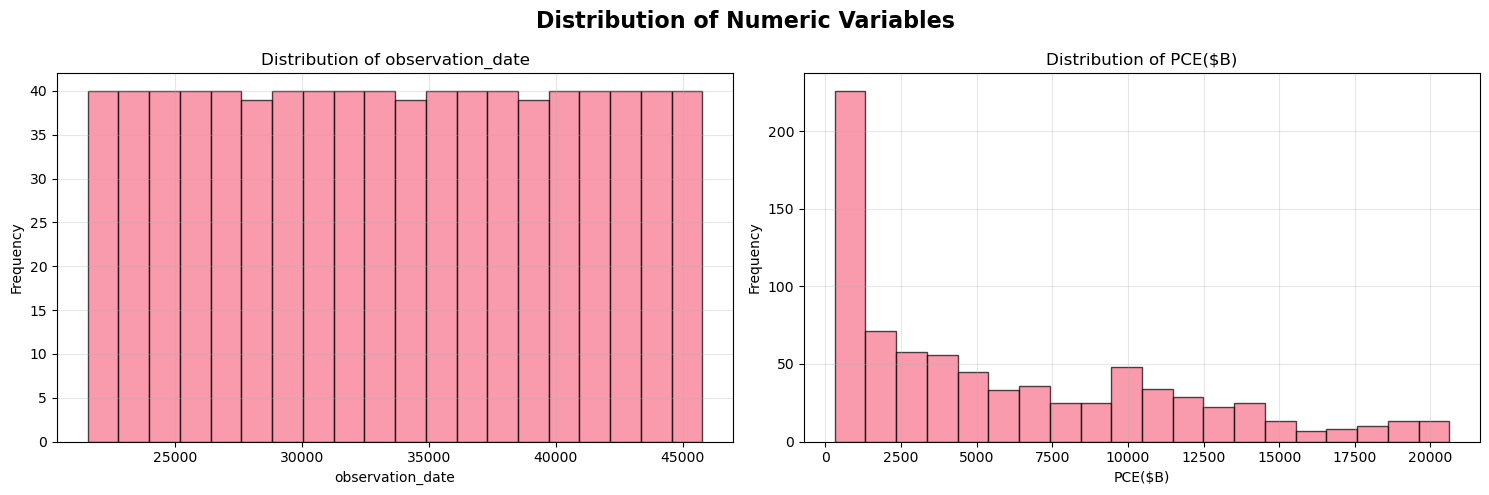

✓ Histograms created successfully


In [35]:
# 1. HISTOGRAMS FOR NUMERIC COLUMNS
if len(numeric_cols) > 0:
    print("Creating histograms for numeric columns...")
    
    # Calculate number of rows and columns for subplots
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=20, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
    
    # Hide extra subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Distribution of Numeric Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✓ Histograms created successfully")
    
else:
    print("No numeric columns found for visualization.")


Creating correlation heatmap...


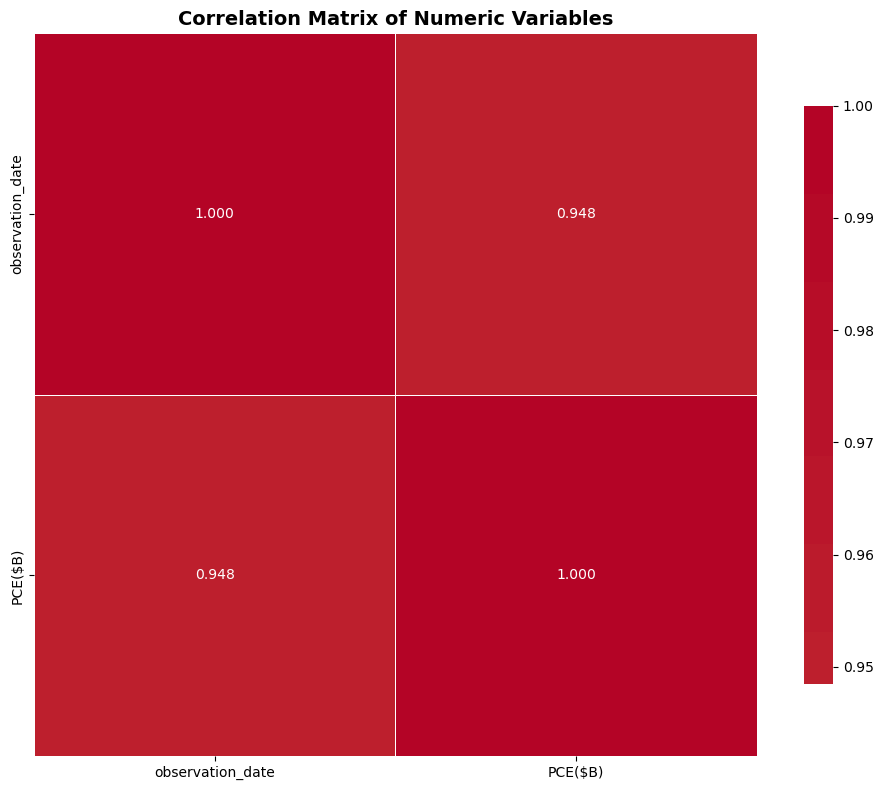

✓ Correlation heatmap created successfully


In [36]:
# 2. CORRELATION HEATMAP
if len(numeric_cols) > 1:
    print("Creating correlation heatmap...")
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, 
               annot=True, 
               cmap='coolwarm', 
               center=0,
               square=True, 
               linewidths=0.5, 
               cbar_kws={"shrink": .8},
               fmt='.3f')
    plt.title('Correlation Matrix of Numeric Variables', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✓ Correlation heatmap created successfully")
    
elif len(numeric_cols) == 1:
    print("Only one numeric column found - correlation matrix not applicable")
else:
    print("No numeric columns for correlation analysis")


Creating box plots for outlier detection...


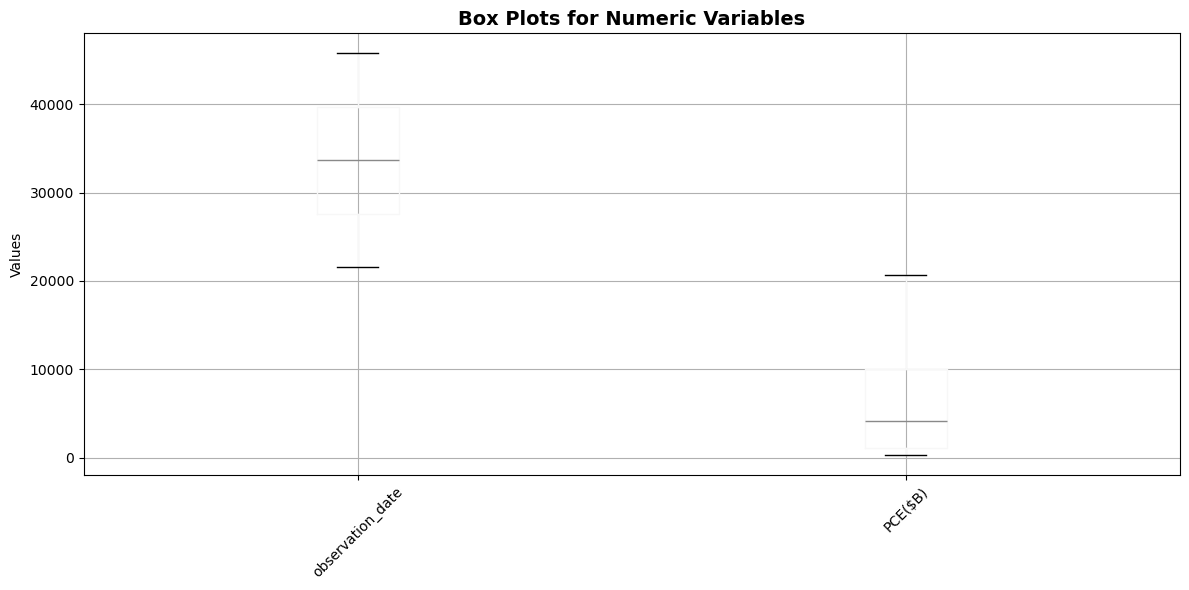

✓ Box plots created successfully

Outlier Analysis:
------------------------------
observation_date: 0 outliers detected
PCE($B): 0 outliers detected


In [37]:
# 3. BOX PLOTS FOR OUTLIER DETECTION
if len(numeric_cols) > 0:
    print("Creating box plots for outlier detection...")
    plt.figure(figsize=(12, 6))
    df[numeric_cols].boxplot()
    plt.title('Box Plots for Numeric Variables', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()
    print("✓ Box plots created successfully")
    
    # Print outlier analysis
    print("\nOutlier Analysis:")
    print("-" * 30)
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers detected")
        
else:
    print("No numeric columns found for box plot analysis.")


Potential date columns found: ['observation_date']
Creating time series plots...


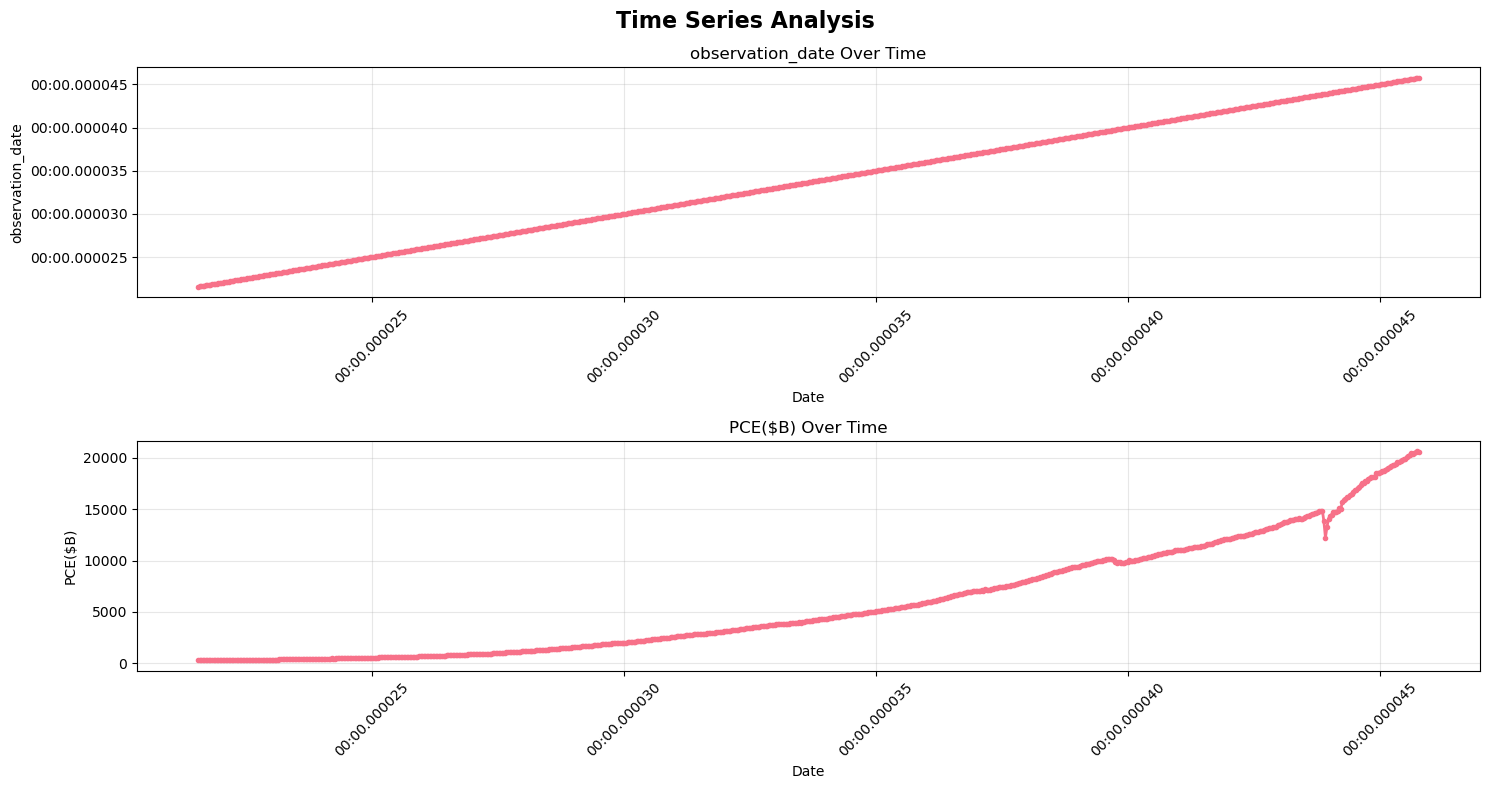

✓ Time series plots created successfully


In [38]:
# Look for date/time columns
date_cols = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['date', 'time', 'year', 'month', 'day']):
        date_cols.append(col)

print(f"Potential date columns found: {date_cols}")

if date_cols and len(numeric_cols) > 0:
    print("Creating time series plots...")
    
    try:
        # Use the first date column
        date_col = date_cols[0]
        df[date_col] = pd.to_datetime(df[date_col])
        df_sorted = df.sort_values(date_col)
        
        # Create time series plots for each numeric column
        fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(15, 4*len(numeric_cols)))
        if len(numeric_cols) == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols):
            axes[i].plot(df_sorted[date_col], df_sorted[col], linewidth=2, marker='o', markersize=3)
            axes[i].set_title(f'{col} Over Time')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(col)
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.suptitle('Time Series Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✓ Time series plots created successfully")
        
    except Exception as e:
        print(f"Error in time series analysis: {e}")
else:
    print("No suitable date/time columns found for time series analysis.")


In [39]:
# Analyze categorical variables
if len(categorical_cols) > 0:
    print("Analyzing categorical variables...")
    
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        value_counts = df[col].value_counts()
        print(f"  Top 5 values:")
        display(value_counts.head())
        
        # Create bar plot for categorical variables (if not too many categories)
        if df[col].nunique() <= 20:
            plt.figure(figsize=(10, 6))
            value_counts.head(10).plot(kind='bar')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            print(f"✓ Distribution plot created for {col}")
        else:
            print(f"  Too many categories ({df[col].nunique()}) to plot - showing top 5 only")
            
else:
    print("No categorical columns found for analysis.")


No categorical columns found for analysis.


In [40]:
# Generate comprehensive summary
print("PCE DATA ANALYSIS SUMMARY")
print("=" * 50)

print(f"Dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

if len(numeric_cols) > 0:
    print(f"\nDetailed Statistics for Numeric Variables:")
    print("-" * 40)
    for col in numeric_cols:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.4f}")
        print(f"  Median: {df[col].median():.4f}")
        print(f"  Std Dev: {df[col].std():.4f}")
        print(f"  Min: {df[col].min():.4f}")
        print(f"  Max: {df[col].max():.4f}")
        print(f"  Range: {df[col].max() - df[col].min():.4f}")

if len(categorical_cols) > 0:
    print(f"\nCategorical Variables Summary:")
    print("-" * 40)
    for col in categorical_cols:
        most_common = df[col].mode()[0]
        count = df[col].value_counts().iloc[0]
        percentage = (count / len(df)) * 100
        print(f"  {col}: Most common is '{most_common}' ({count} times, {percentage:.1f}%)")

print("\n" + "=" * 50)
print("ANALYSIS COMPLETE!")
print("=" * 50)


PCE DATA ANALYSIS SUMMARY
Dataset shape: (797, 2)
Total columns: 2
Numeric columns: 2
Categorical columns: 0
Missing values: 0
Duplicate rows: 0

Detailed Statistics for Numeric Variables:
----------------------------------------

observation_date:
  Mean: .4f
  Median: .4f


TypeError: unsupported format string passed to Timedelta.__format__